In [1]:
import os
import re
from pathlib import Path

import anndata
import pandas as pd
import scanpy as sc
import sklearn
import scipy
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [2]:
# !pip install git+https://github.com/estorrs/mgitools

In [3]:
# !pip install scanpy==1.9.1

In [4]:
from wombat.utils import listfiles

In [5]:
output_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/SpiceMix/analysis/brca_dcis/combined_run_1/inputs/files'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [12]:
fps = sorted(listfiles('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/',
                       regex=r'outs/filtered_feature_bc_matrix.h5$'))
# fps = [fp for fp in fps if 'CRISPR' not in fp]
# fps = [fp for fp in fps if '242P1' in fp]
len(fps), fps

(18,
 ['/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/BRCA_206B1/BR_206B1_U1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/BRCA_206B1/BR_206B1_U2/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/BRCA_206B1/BR_206B1_U3/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/BRCA_206B1/BR_206B1_U4/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/BRCA_206B1/BR_206B1_U5/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/HT308B1/HT308B1-S1H1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcrip

BR_206B1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


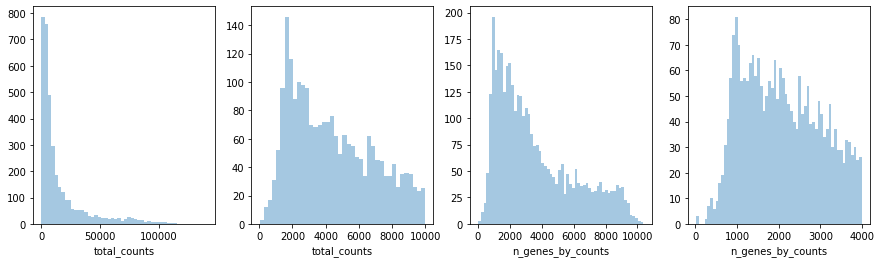

BR_206B1_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


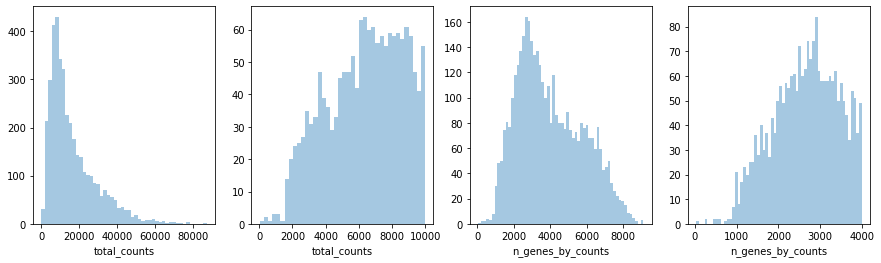

BR_206B1_U3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


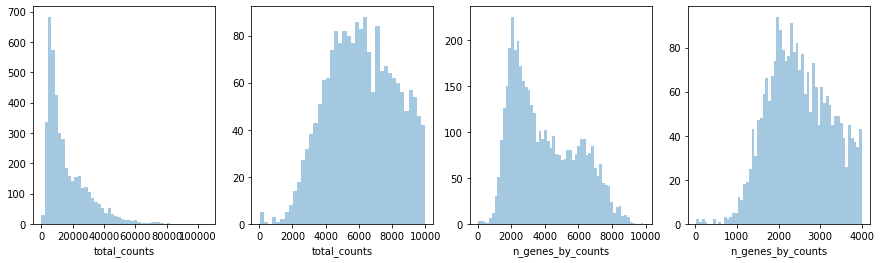

BR_206B1_U4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


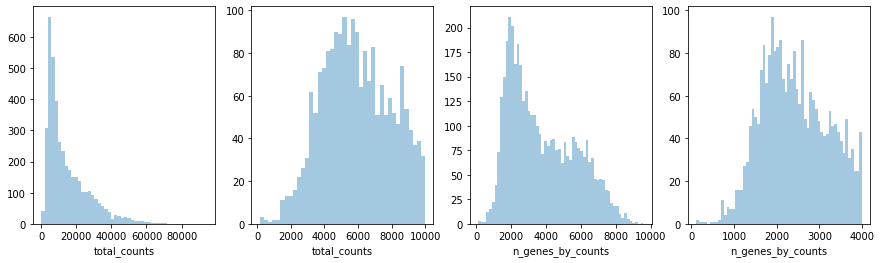

BR_206B1_U5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


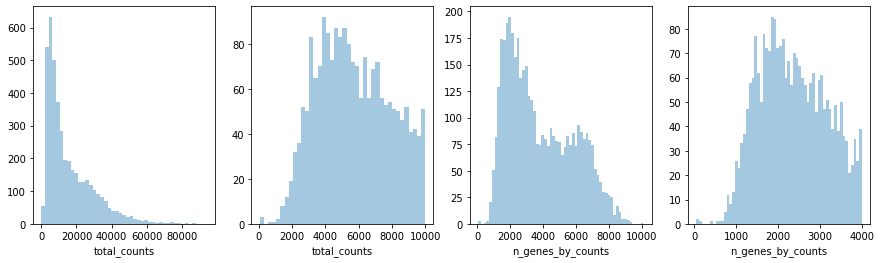

HT308B1-S1H1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


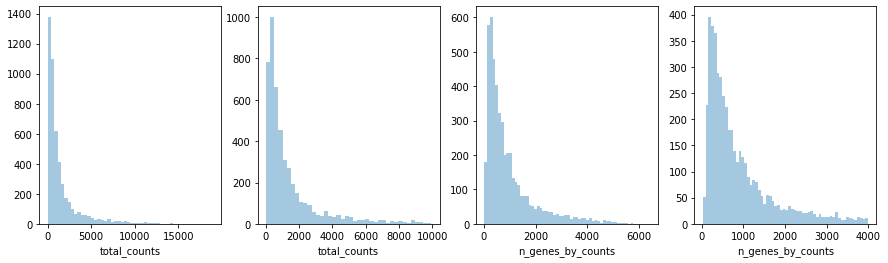

HT308B1-S1H4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


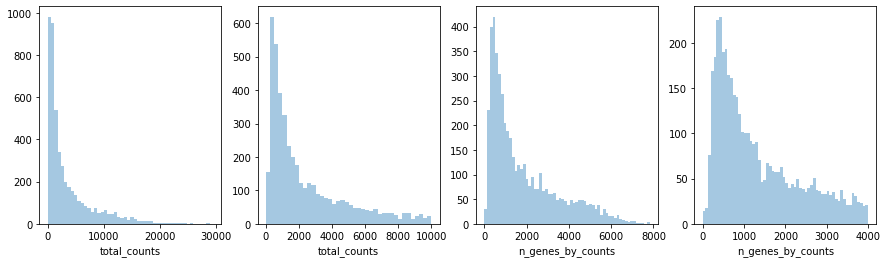

HT308B1-S1H5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


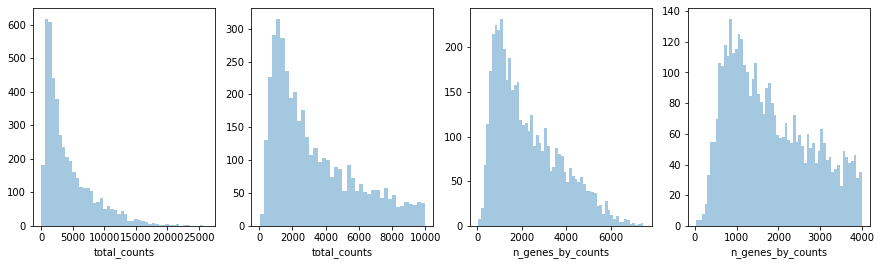

HT308B1-S2H5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


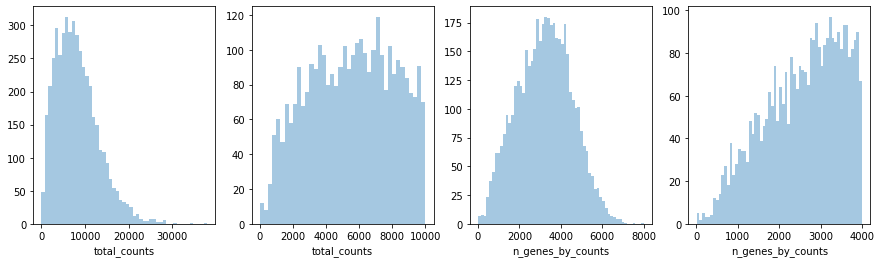

HT323B1-S1H1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


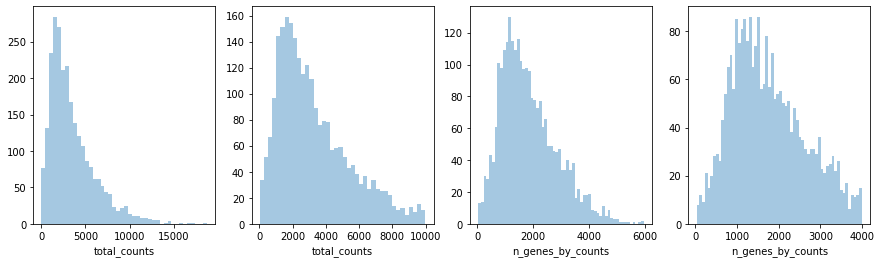

HT323B1-S1H3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


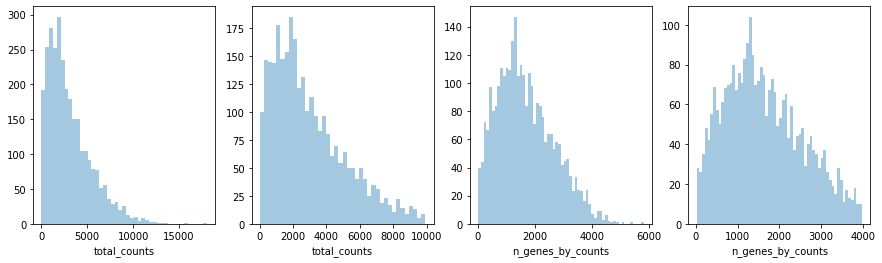

HT339B1-S1H3_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


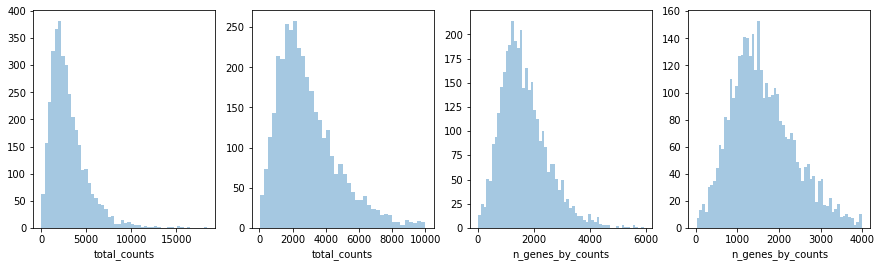

HT339B1-S1H3_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


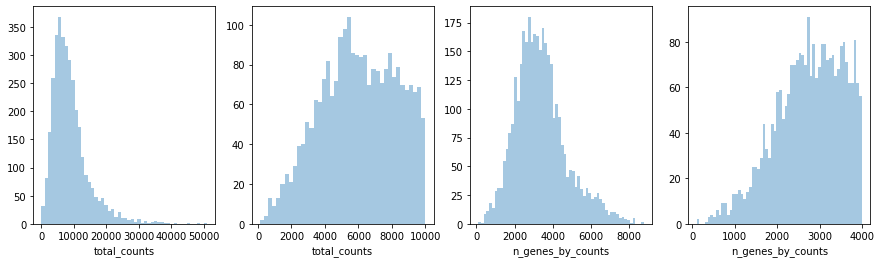

HT397B1-S1H2Fs4U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


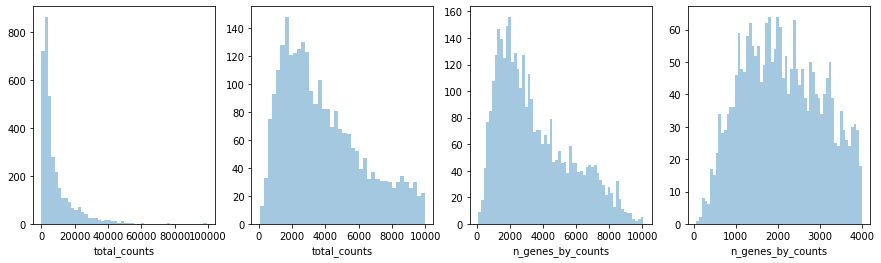

HT397B1-S1H3Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


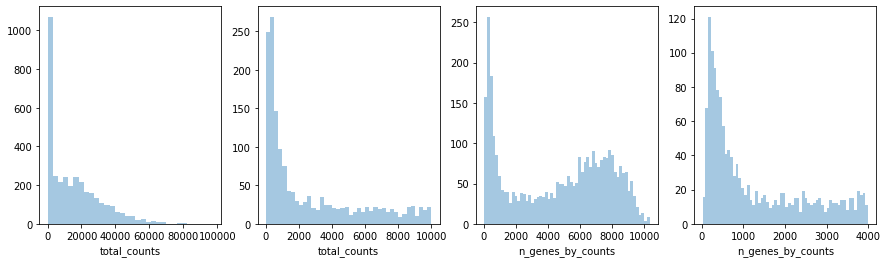

HT480B1-S1H1Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


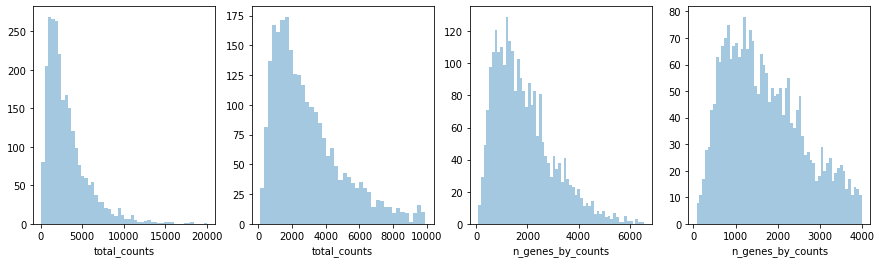

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


HT480B1-S1H3Fs1U1Bp1


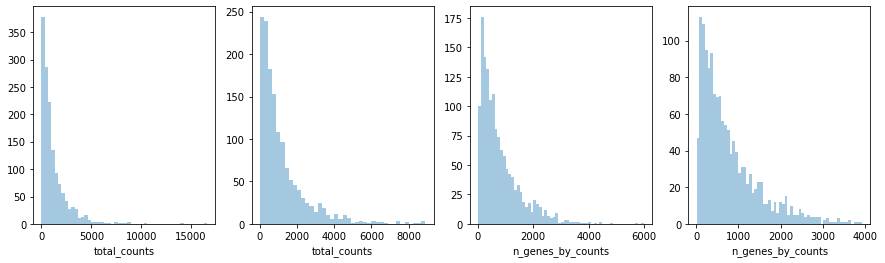

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


HT486B1-S1H1Fs1U1Bp1


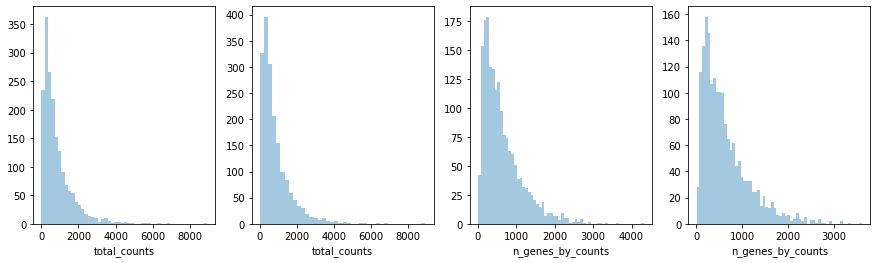

dict_keys(['BR_206B1_U1', 'BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5', 'HT308B1-S1H1', 'HT308B1-S1H4', 'HT308B1-S1H5', 'HT308B1-S2H5', 'HT323B1-S1H1', 'HT323B1-S1H3', 'HT339B1-S1H3_U1', 'HT339B1-S1H3_U2', 'HT397B1-S1H2Fs4U1Bp1', 'HT397B1-S1H3Fs1U1Bp1', 'HT480B1-S1H1Fs1U1Bp1', 'HT480B1-S1H3Fs1U1Bp1', 'HT486B1-S1H1Fs1U1Bp1'])

In [13]:
sample_to_adata = {}
for i, fp in enumerate(fps):
    s = fp.split('/')[-3]
    print(s)
    a = sc.read_visium(fp.replace('/filtered_feature_bc_matrix.h5', ''))
    a.var_names_make_unique()
    a.var["mt"] = a.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)
    a.obs.index = [f'{s}_{x}' for x in a.obs.index]
    a.obs['sample_id'] = s
    a.obs['fov'] = str(i)
    sample_to_adata[s] = a

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.distplot(a.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(a.obs["total_counts"][a.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.distplot(a.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(a.obs["n_genes_by_counts"][a.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
    plt.show()

sample_to_adata.keys()

In [14]:
for s, a in sample_to_adata.items():
    print(a.shape)
#     sc.pp.filter_cells(a, min_counts=1000)
#     a = a[a.obs["pct_counts_mt"] < 20]
    
    sc.pp.normalize_total(a, target_sum=10e4)
    sc.pp.log1p(a)
    
    a.raw = a
    
    sample_to_adata[s] = a
    
    print(a.shape)

(3651, 36601)
(3651, 36601)
(3949, 36601)
(3949, 36601)
(4311, 36601)
(4311, 36601)
(4132, 36601)
(4132, 36601)
(4274, 36601)
(4274, 36601)
(4839, 36601)
(4839, 36601)
(4867, 36601)
(4867, 36601)
(4568, 36601)
(4568, 36601)
(4631, 36601)
(4631, 36601)
(2542, 36601)
(2542, 36601)
(2950, 36601)
(2950, 36601)
(3596, 36601)
(3596, 36601)
(3488, 36601)
(3488, 36601)
(3561, 17943)
(3561, 17943)
(3494, 17943)
(3494, 17943)
(2556, 17943)
(2556, 17943)
(1445, 17943)
(1445, 17943)
(1832, 17943)
(1832, 17943)


In [15]:
def spot_to_neighbors(adata, n_neighbors=7, radius=400.):
    X = adata.obsm['spatial']
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.kneighbors_graph(X, n_neighbors=n_neighbors, )
#     g = nbrs.radius_neighbors_graph(X, radius=radius, )
    rows, cols, _ = scipy.sparse.find(g)
    
    spot_to_neighbhors = {x:[] for x in adata.obs.index.to_list()}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        spot_to_neighbhors[cid].append(adata.obs.index[c])
    spot_to_neighbhors = {spot:[nbhr for nbhr in nbhrs if nbhr != spot]
                          for spot, nbhrs in spot_to_neighbhors.items()}
    return spot_to_neighbhors

In [16]:
for s, a in sample_to_adata.items():
    a.uns['spot_to_neighbors'] = spot_to_neighbors(a)

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fov' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering ca

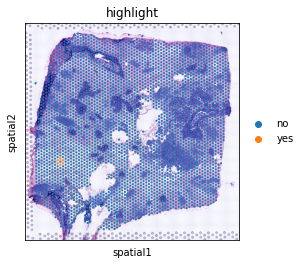

In [17]:
test = next(iter(sample_to_adata.values()))
test.obs['highlight'] = ['yes' if x in test.uns['spot_to_neighbors'][test.obs.index[100]] else 'no'
                      for x in test.obs.index]
sc.pl.spatial(test, color='highlight')

In [18]:
combined = anndata.concat(sample_to_adata.values())
combined.uns['spot_to_neighbors'] = {}
for s, a in sample_to_adata.items():
    combined.uns['spot_to_neighbors'].update(a.uns['spot_to_neighbors'])

combined

AnnData object with n_obs × n_vars = 64686 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [19]:
# limit to genes with > 10% expression accross samples
combined.raw = combined
sc.pp.filter_genes(combined, min_counts=int(.1 * combined.shape[0]))
combined

AnnData object with n_obs × n_vars = 64686 × 11381
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov'
    var: 'n_counts'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [20]:
genes = combined.var.index.to_list()

In [21]:
for s, a in sample_to_adata.items():
    print(s)
    fov = a.obs['fov'][0]
    gene_table = a[:, genes].var[[]]
    gene_table.index.name = 'Gene'

    meta = a.obs[['array_row', 'array_col']]
    meta.columns = ['coor Y', 'coor X']

    exp = pd.DataFrame(data=a[:, genes].X.toarray(), columns=genes, index=a.obs.index)

    spot_to_index = {spot:i for i, spot in enumerate(a.obs.index)}
    edges = [[spot_to_index[spot1], spot_to_index[spot2]]
             for spot1, nbhrs in a.uns['spot_to_neighbors'].items()
             for spot2 in nbhrs]
    edges = pd.DataFrame(data=edges, columns=['Spot', 'Neighbor'])

    gene_table.to_csv(os.path.join(output_dir, f'genes_{fov}.txt'), sep='\t', index=True, header=False)
    meta.to_csv(os.path.join(output_dir, f'meta_{fov}.txt'), sep='\t', index=False, header=True)
    exp.to_csv(os.path.join(output_dir, f'expression_{fov}.txt'), sep='\t', index=False, header=False)
    edges.to_csv(os.path.join(output_dir, f'neighborhood_{fov}.txt'), sep='\t', index=False, header=False)

In [1]:
directory = os.path.join(output_dir, '..', 'input_adatas')
Path(directory).mkdir(parents=True, exist_ok=True)
for s, a in sample_to_adata.items():
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

NameError: name 'os' is not defined